# Expectation Maximization implementation for Gaussian Mixture Models

## Gaussian Mixture Model

- A **Gaussian Mixture Model (GMM)** assumes that a dataset is generated from multiple Gaussian distributions, 
  - each with its own **mean** and **covariance**. 
- Unlike K-means, GMM allows **soft assignments**, meaning each point belongs to clusters with certain probabilities rather than hard labels.

A GMM with **K components** has the following parameters: 
- **`π_k`**: Mixing coefficients (weights) for each Gaussian (sum to 1) 
- **`μ_k`**: Mean vector for each Gaussian
- **`σ_k`**: Covariance matrix for each Gaussian

```
p(x)=∑ ​π_k​ ⋅ N(x ∣ μ_k​, σ_k​)   
```
- `∑` for k=1 to K
- `N(x ∣ μ_k​, σ_k​)` is gaussian density



## Expectation Maximization 

- The EM algorithm is an **iterative approach** to estimate the parameters `Θ={π_k, μ_k, σ_k}` given observed data `X={x_1, x_2, ..., x_n}`


### Steps 

####  Step 0: initialization

1. Randomly initialize the **means** `μ_k`​, **covariances** `σ_k`, and **mixing coefficients** `π_k`.
2. Set convergence criteria (e.g., change in log-likelihood below a threshold).

#### Step 1: E step

1. Compute the responsibility `r_ik`, which represents the probability that point `x_i` was generated by Gaussian `k`.

```
r_ik ​=  ​π_k ⋅ ​N(x_i​∣ μ_j​, σ_j​) / Σ π_k ⋅ ​N(x_i​∣ μ_k​, σ_k​)
```


#### Step 2: M step

Update the parameters using the computed responsibilities:

- Mixing Coefficients:
  - mixing coefficient π_j is the average of all responsibilities 
    - `π_k ​= 1/N ∑ ​r_ik​`
- Mean of distributions:
  - is the weighted mean of all points in k
    - `μ_k​ = ∑​ r_ik x_i  /  ​∑r_ik`
    - ==> `μ = R ⋅ X / ​∑r_ik`
- CoVariance Matrices
  - is the wighted variance of each cluster
    - `σ_k​ = ∑​ r_ik (x_i - μ_k​)(x_i - μ_k​)T  /  ​∑r_ik`

#### Step 3: Calculate the log-likelihood

```
log L(Θ) = ∑ log(∑K​ π_k ​N(x_i​∣ μ_k​, σk​))
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd

# Generate synthetic data
np.random.seed(42)
mu1, sigma1 = [2, 2], [[1, 0.5], [0.5, 1]]
mu2, sigma2 = [6, 6], [[1, -0.3], [-0.3, 1]]
mu3, sigma3 = [10, 2], [[1, 0.2], [0.2, 1]]

data1 = np.random.multivariate_normal(mu1, sigma1, 100)
data2 = np.random.multivariate_normal(mu2, sigma2, 100)
data3 = np.random.multivariate_normal(mu3, sigma3, 100)
X = np.vstack((data1, data2, data3))

# Number of clusters
K = 3
# Number of samples 
N, _ = X.shape

In [2]:
### Step 0: Initialize parameters
np.random.seed(42)

# Equal mixing coefficients
pi = np.ones(K) / K  

# Randomly chosen means
mu = X[np.random.choice(N, K, replace=False)]

# Shared covariance
sigma = np.array([np.cov(X.T) for _ in range(K)])  

# Set some threshold for how many to look into 
max_iter = 100

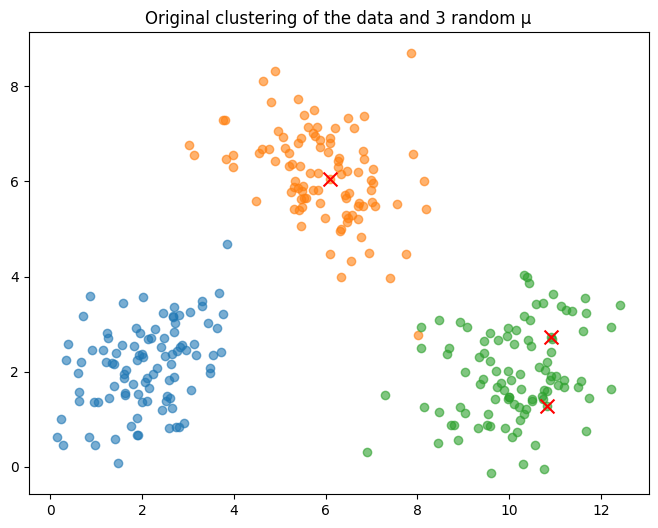

In [3]:

## Look at the original clustering
plt.figure(figsize=(8, 6))
plt.scatter(data1[:, 0], data1[:, 1],  alpha=0.6)
plt.scatter(data2[:, 0], data2[:, 1],  alpha=0.6)
plt.scatter(data3[:, 0], data3[:, 1],  alpha=0.6)
plt.scatter(mu[:, 0], mu[:, 1], c='red', marker='x', s=100)
plt.title('Original clustering of the data and 3 random μ')
plt.show()


Going through EM steps in each cell to investigate. 

In [4]:
### E-step: Compute responsibilities
r = np.zeros((N, K))
for k in range(K):
    # r_ik = ​π_k ⋅ ​N(x_i​∣ μ_j​, σ_j​) / Σ π_k ⋅ ​N(x_i​∣ μ_k​, σ_k​)
    # r_ik = ​π_k ⋅ ​N(x_i​∣ μ_j​, σ_j​) ==> then normalize 
    r[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])

# Normalize to the total responsibilities 
r /= r.sum(axis=1, keepdims=True)
r.shape

(300, 3)

responsibilites: `r_ik` determine how much each gaussian dist is responsible for each data point

In [5]:
## M Step: 
## 1. Update π_k = 1/N ∑ ​r_ik

Nk = r.sum(axis=0)  # Effective number of points per cluster
print('Nk = ∑ ​r_ik (sum for all i) =', Nk)

pi = Nk / K 
print('π_k =', pi)

Nk = ∑ ​r_ik (sum for all i) = [ 78.46255442  77.72657386 143.81087172]
π_k = [26.15418481 25.90885795 47.93695724]


In [6]:
## 2. Update μ_k​ = ∑​ r_ik x_i  /  ​∑r_ik`
##    - ==> `μ = R ⋅ X / ​∑r_ik`

mu_updated = r.T @ X # (300, 3)T @ (300, 2) ==> (3, 2)
mu_updated = mu_updated  / Nk.reshape(3,1) # (3, 2 ) / (3, 1)

mu = mu_updated
mu

array([[7.49922875, 2.55131871],
       [7.26507761, 1.95804454],
       [4.58182741, 4.64324492]])

In [7]:
# Update CoVariance Matrices
#   - is the wighted variance of each cluster
#     - `σ_k​ = ∑​ r_ik     (x_i - μ_k​)      (x_i - μ_k​)T  /  ​∑r_ik`
#               (300,)  *  (300, 2)     @   (300, 2)     /  (1,1)  ==must_give==>  (2,2) because we need once σ for each data axis
#             [(300, 1) * (300, 2) ].T  @   (300, 2)
#             [      (300, 2)      ].T  @   (300, 2)
#                     (2, 300)          @   (300, 2) ===> (2,2)
for k in range(K):
    X_standard = X - mu[k]
    # r[:, k] has a shape of (300, )
    # it needs to be (300, 1) so that I can multiply it to X_standarad
    #    solution: r[:, k].reshape(300,1)  
    #       or     r[:, k][:, np.newaxis]
    sigma[k] = (
        (
            r[:,k][:, np.newaxis] * X_standard
        ).T @ X_standard / Nk[k]  
    )

sigma

array([[[12.8602885 , -0.2584591 ],
        [-0.2584591 ,  2.40486842]],

       [[14.71920975,  0.14693077],
        [ 0.14693077,  1.44183394]],

       [[ 5.43396558,  2.8283218 ],
        [ 2.8283218 ,  4.429226  ]]])

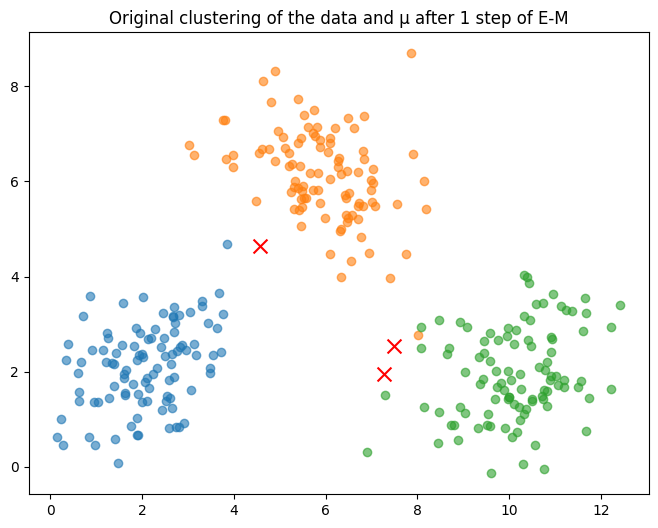

In [8]:

## Look at the original clustering
plt.figure(figsize=(8, 6))
plt.scatter(data1[:, 0], data1[:, 1],  alpha=0.6)
plt.scatter(data2[:, 0], data2[:, 1],  alpha=0.6)
plt.scatter(data3[:, 0], data3[:, 1],  alpha=0.6)
plt.scatter(mu[:, 0], mu[:, 1], c='red', marker='x', s=100)
plt.title('Original clustering of the data and μ after 1 step of E-M')
plt.show()


In [9]:
### Step 0: Initialize parameters
np.random.seed(42)

# Equal mixing coefficients
pi = np.ones(K) / K  

# Randomly chosen means
mu = X[np.random.choice(N, K, replace=False)]

# Shared covariance
sigma = np.array([np.cov(X.T) for _ in range(K)])  

# Set some threshold for how many to look into 
max_iter = 100

##### Put things together: 

log_likelihoods = []
mues = []

for step in range(max_iter):
 
    ### E-step: Compute responsibilities
    r = np.zeros((N, K))
    for k in range(K):
        # r_ik = ​π_k ⋅ ​N(x_i​∣ μ_j​, σ_j​) / Σ π_k ⋅ ​N(x_i​∣ μ_k​, σ_k​)
        # r_ik = ​π_k ⋅ ​N(x_i​∣ μ_j​, σ_j​) ==> then normalize 
        r[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
    r /= r.sum(axis=1, keepdims=True)
    
    ### M-step: Update parameters
    Nk = r.sum(axis=0)  # Effective number of points per cluster
    pi = Nk / N  # Update mixing coefficients

    # Update means
    mu = (r.T @ X) / Nk[:, np.newaxis]  
    for k in range(K):
        X_standard = X - mu[k]
        sigma[k] = (
            (
                r[:,k][:, np.newaxis] * X_standard
            ).T @ X_standard / Nk[k]  
        )
    
    # Compute log-likelihood
    log_likelihood = np.sum(np.log(np.sum([pi[k] * multivariate_normal.pdf(X, mu[k], sigma[k]) for k in range(K)], axis=0)))
    log_likelihoods.append(log_likelihood)
    mues.append(mu)
    
    # Check convergence
    if step > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-6:
        break

mues = pd.DataFrame([m.flatten() for m in mues], columns=['m1x', 'm1y', 'm2x','m2y', 'm3x', 'm3y'])

print(f"steps {step}")

steps 60


Text(0.5, 1.0, 'Changes in μ')

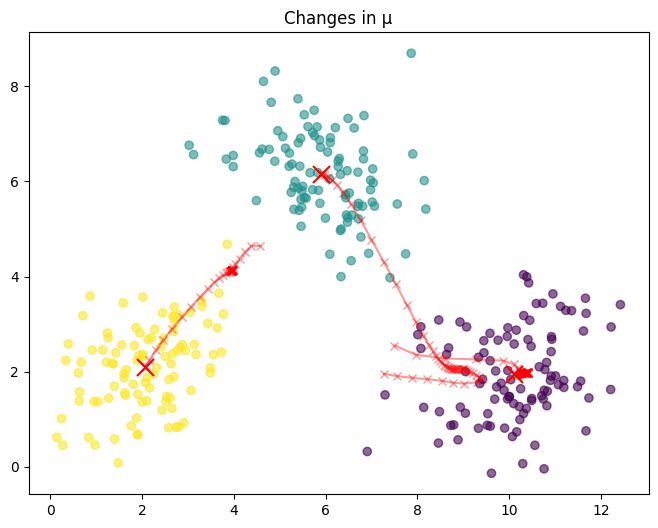

In [10]:

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=r.argmax(axis=1), cmap='viridis', alpha=0.6)
plt.plot(mues['m1x'], mues['m1y'], marker='x', c='red', alpha=.4)
plt.plot(mues['m2x'], mues['m2y'], marker='x', c='red', alpha=.4)
plt.plot(mues['m3x'], mues['m3y'], marker='x', c='red', alpha=.4)
plt.scatter(mu[:, 0], mu[:, 1], c='red', marker='x', s=150)
plt.title('Changes in μ')

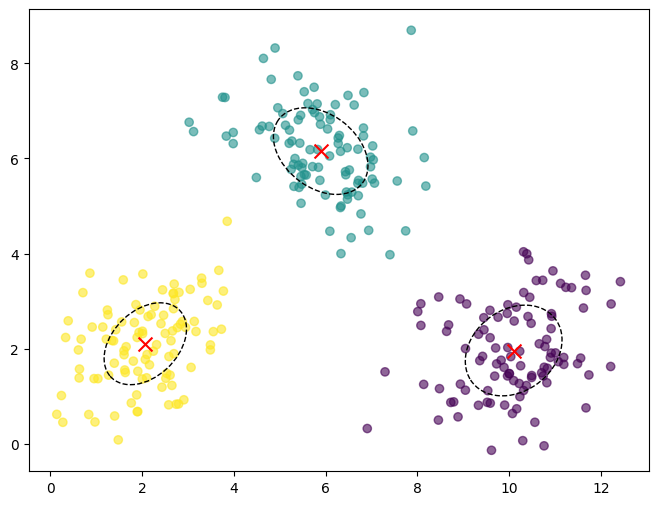

In [11]:
# ChatGPT helped with the Ellipses. 

import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=r.argmax(axis=1), cmap='viridis', alpha=0.6)
plt.scatter(mu[:, 0], mu[:, 1], c='red', marker='x', s=100, label='Centroids')

# Plot covariance as ellipses
for k in range(K):
    eigvals, eigvecs = np.linalg.eigh(sigma[k])  
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))  
    width, height = 2 * np.sqrt(eigvals)  
    ellipse = mpatches.Ellipse(xy=mu[k], width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
    plt.gca().add_patch(ellipse)
